The finding of adequate hyper parameters is crucial to improve the performance and generalization of machine learning models. There are several methods described in modern literature that can help to find the best fitting hyper parameters. The performance is tested in different dataset that are tested and well studied, such as MINST. Hyper parameters (HP) are external to the learning process but significantly impact model performance. HP are external to the learning process but significantly impact model performance. Effective tuning typically requires domain expertise or computationally expensive methods like brute-force search.
Effective tuning typically requires domain expertise or computationally expensive methods like brute-force search In [1, 2, 3], the Bayesian optimization is explored.  Bayesian optimization leverages prior knowledge to update posterior distributions based on sample data, guiding the search for optimal hyperparameter configurations efficiently. Traditional approaches like grid search and random search are computationally expensive and less effective in high-dimensional spaces. Bayesian optimization offers a more efficient alternative, particularly for expensive, black-box objective functions. 
In [1] the use of Bayesian optimization is explored for tuning hyper parameters in machine learning models, which is critical for improving model performance. The study proposes a method using Bayesian optimization with Gaussian processes. Traditional approaches like grid search and random search are computationally expensive and less effective in high-dimensional spaces. Bayesian optimization offers a more efficient alternative, particularly for expensive, black-box objective functions. The results were conducted on machine learning models like random forests, neural networks (CNN and RNN), and deep forests (gcForest). Bayesian optimization demonstrated significant improvements in prediction accuracy and computational efficiency compared to traditional methods.The results confirm that Bayesian optimization outperforms other optimization techniques in terms of speed and achieving better model performance, especially in scenarios with limited computational resources or high-dimensional hyperparameter spaces.

In [2] it is stated that complex models like Deep Belief Networks (DBNs) have numerous hyper parameters, making manual optimization inefficient and inconsistent.
The difficulty in tuning these models hinders reproducibility and progress in machine learning research. Therefore, the proposed approaches is based on
Random Search, a method where hyper parameters are sampled randomly from predefined distributions. It is efficient for simple problems but struggles with complex models like DBNs. In order to improve this disadvantage, the Sequential Model-Based Optimization is introduced.
This method approximates the loss function with a surrogate model to guide the search. Two specific variants of the methods are explained: Gaussian Process and the
Tree-Structured Parzen Estimator. Both methods were tested on DBNs with up to 32 hyper parameters across tasks like image classification on datasets such as MNIST and MRBI. The results show, that Random search matched human manual optimization for simple tasks but failed for harder datasets.
Tree-Structured Parzen Estimator consistently outperformed both random search and manual tuning, achieving better accuracy and efficiency.The Gaussian Process was effective but less efficient than TPE due to computational overhead.

In [3], the results proves that experiments were conducted on machine learning models like random forests, neural networks (CNN and RNN), and deep forests (gcForest). Bayesian optimization demonstrated significant improvements in prediction accuracy and computational efficiency compared to traditional methods.
The results confirm that Bayesian optimization outperforms other optimization techniques in terms of speed and achieving better model performance, especially in scenarios with limited computational resources or high-dimensional hyperparameter spaces.





[1] Hyunghun Cho et al.: *Basic Enhancement Strategies When Using Bayesian Optimization for Hyperparameter Tuning of Deep Neural Networks*, Special section on scalable deeo learning for big data, VOLUME 8, Digital Object Identifier 10.1109/ACCESS.2020.2981072, pp. 52588-52608 IEEE Access, 2020

[2] James Bergstra et al: *Algorithms for Hyper-Parameter Optimization*, NIPS'11: Proceedings of the 24th International Conference on Neural Information Processing Systems,  pp. 2546 - 2554, 2011

[3] Jia Wu et al: *Hyperparameter Optimization for Machine Learning Models Based on Bayesian Optimization*, Journal of Electronic Science , VOL. 17, NO. 1,Digital Object Identifier:10.11989/JEST.1674-862X.80904120, pp.26 - 40, 2019, 

Prep data and environment and Import MINST dataset 

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt import BayesSearchCV
from skopt import gp_minimize
# objective function
from sklearn.model_selection import cross_val_score
from skopt.utils import use_named_args

## necessary libraries to build model tensorflow (objective funciton)
import tensorflow as tf
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import GPyOpt


In [ ]:
# Load MNIST dataset
# Split into training and testing datasets
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255


In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 10)

https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html\
https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py\
https://www.linkedin.com/pulse/optimizing-machine-learning-models-bayesian-deep-dive-davis-joseph-qsqje?utm_source=share&utm_medium=member_android&utm_campaign=share_via


In [6]:
print(X_val.shape)

(10000, 28, 28)


In [7]:
# define the model as objective function()
def build_model(learning_rate, units_layer01,units_layer02, l2_reg):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(units=units_layer01, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=units_layer02, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=10, activation='softmax'))
    return model

In [20]:
def model_score(params):
    learning_rate = float(params[:, 0])
    units_layer01 = int(params[:, 1])
    units_layer02 = int(params[:, 2])
    l2_reg = float(params[:, 3])
    batch_size = int(params[:, 4])

    model = build_model(learning_rate, units_layer01,units_layer02,  l2_reg)
    #model.summary()
    checkpoint_folder = "checkpoints/"
    checkpoint_path = checkpoint_folder +  f'checkpoint_lr_{learning_rate}_units_layer01_{units_layer01}_units_layer02_{units_layer02}_l2_{l2_reg}_batch_{batch_size}.keras' #h5
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=15, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, monitor='val_mse', save_best_only=True, verbose=1)
    ]
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['mse'])
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=50,
                        callbacks=callbacks,
                        verbose=0)
    
    val_mse = np.max(history.history['val_mse'])
    return -val_mse


(60000, 28, 28)


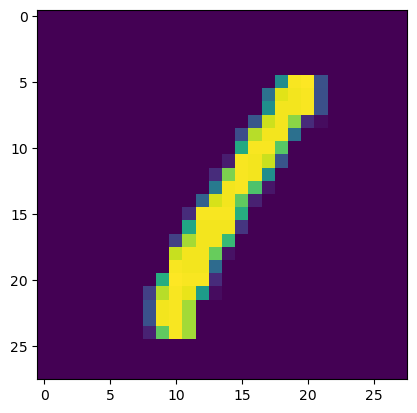

y_train category [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


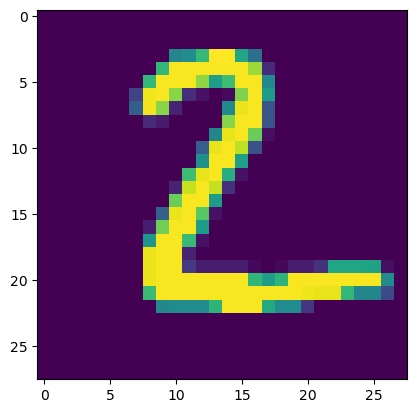

y_val category: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
import matplotlib.pyplot as plt
m = X_train.shape
print(m)
plt.imshow(X_train[3])
plt.show()
print("y_train category", y_train[3])
plt.imshow(X_val[1])
plt.show()
print("y_val category:", y_val[1])


In [ ]:
# Define the bounds of the hyperparameters
bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-5, 1e-1)},
    {'name': 'units_layer01', 'type': 'discrete', 'domain': (16, 32, 64, 128, 256)},
    {'name': 'units_layer02', 'type': 'discrete', 'domain': (16, 32, 64, 128, 256)},
    {'name': 'l2_reg', 'type': 'continuous', 'domain': (1e-6, 1e-2)},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (16, 32, 64, 128)}
]

# Perform Bayesian Optimization
optimizer = GPyOpt.methods.BayesianOptimization(f=model_score, 
                                                domain=bounds, 
                                                acquisition_type='EI'  # Expected Improvement
)
#optimizer.run_optimization(max_iter=30, verbosity=True, eps=1e-6)



Epoch 1: val_mse improved from inf to 0.09028, saving model to checkpoints/checkpoint_lr_0.08723775514781722_units_layer01_128_units_layer02_16_l2_0.005574673782382699_batch_16.keras

Epoch 2: val_mse did not improve from 0.09028

Epoch 3: val_mse did not improve from 0.09028

Epoch 4: val_mse improved from 0.09028 to 0.09019, saving model to checkpoints/checkpoint_lr_0.08723775514781722_units_layer01_128_units_layer02_16_l2_0.005574673782382699_batch_16.keras

Epoch 5: val_mse did not improve from 0.09019

Epoch 6: val_mse did not improve from 0.09019

Epoch 7: val_mse did not improve from 0.09019

Epoch 8: val_mse did not improve from 0.09019

Epoch 9: val_mse improved from 0.09019 to 0.09013, saving model to checkpoints/checkpoint_lr_0.08723775514781722_units_layer01_128_units_layer02_16_l2_0.005574673782382699_batch_16.keras

Epoch 10: val_mse did not improve from 0.09013

Epoch 11: val_mse did not improve from 0.09013

Epoch 12: val_mse did not improve from 0.09013

Epoch 13: val

In [23]:
optimizer.run_optimization(max_iter=30, verbosity=True, eps=1e-6)


Epoch 1: val_mse improved from inf to 0.04451, saving model to checkpoints/checkpoint_lr_0.038835490520284635_units_layer01_128_units_layer02_64_l2_0.004401478381980411_batch_16.keras

Epoch 2: val_mse improved from 0.04451 to 0.03535, saving model to checkpoints/checkpoint_lr_0.038835490520284635_units_layer01_128_units_layer02_64_l2_0.004401478381980411_batch_16.keras


KeyboardInterrupt: 

36


ValueError: x and y must have same first dimension, but have shapes (36,) and (35, 1)

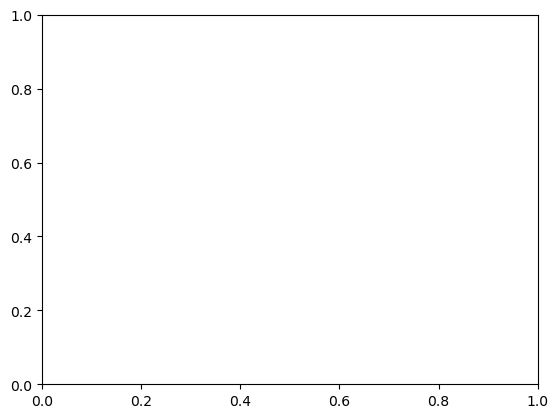

In [24]:

opt_res_param = optimizer.X
print(len(opt_res_param))
opt_res_score = optimizer.Y
plt.plot(opt_res_param[:, 3], opt_res_score)

In [ ]:
import re
import os

# Specify the folder path
folder_path = "checkpoints"

# Get all file names in the folder
file_names = os.listdir(folder_path)

# Print the file names
file_names_vec = []
for file_name in file_names:
    file_names_vec.append(file_name)

def get_BO_values(filenames):
    
    for(filename in file_names):
        # Input string
        input_string = filename

        # Regular expression to extract key-value pairs
        pattern = r"(\w+)_([\d\.]+)"  # Matches "key_value" pairs
        matches = re.findall(pattern, input_string)

        # Convert to dictionary
        parameters = {key: float(value) if '.' in value else int(value) for key, value in matches}

        # Access specific parameters
        lr = round(parameters.get("lr", 0), 3)
        units = parameters.get("units", 0)
        l2 = round(parameters.get("l2", 0), 3)
        batch = parameters.get("batch", 0)


In [26]:
file_names_vec[1]

'checkpoint_lr_0.00517534614537441_units_128_l2_0.000957983117723653_batch_64.keras'